In [461]:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf

from sklearn.model_selection import train_test_split

sys.path.append('..')

from src import CustomTokenizer

In [170]:
train_df = pd.read_csv('../data/train.csv')
print(train_df.shape)

(300000, 5)


In [210]:
train_df['POI'] , train_df['street'] = zip(*train_df['POI/street'].str.split(pat='/'))

def add_start_stop_token(sentence):
    return ('START ' + sentence + ' STOP').replace('  ', ' ')

train_df['street_v2'] = train_df['street'].apply(add_start_stop_token)

train_df.head()

,id,raw_address,POI/street,POI,street,street_v2
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,START jl kapuk timur delta sili iii lippo cika...
1,1,"aye, jati sampurna",/,,,START STOP
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,START siung STOP
3,3,"toko dita, kertosono",toko dita/,toko dita,,START STOP
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru,START jl. orde baru STOP


In [211]:
train_df[train_df['POI']==''].id.count()

178509

In [212]:
train_df[train_df['street']==''].id.count()

70143

## Split train-valid

In [511]:
train, valid = train_test_split(train_df, test_size=0.2, random_state=42)
train = train.sample(n=5000, random_state=42)
train.shape, valid.shape

((5000, 6), (60000, 6))

## Tokenize data

In [512]:
texts = train.raw_address.tolist() + train['street_v2'].tolist()
len(texts)

10000

In [513]:
tokenizer = CustomTokenizer.CustomTokenizer(train_texts = texts)
# fit on the train
tokenizer.train_tokenize()
tokenized_X_train = tokenizer.vectorize_input(train['raw_address'])
tokenized_y_train = tokenizer.vectorize_input(train['street_v2'])
tokenized_X_valid = tokenizer.vectorize_input(train['raw_address'])
tokenized_y_valid = tokenizer.vectorize_input(train['street_v2'])
tokenized_X_train.shape, tokenized_y_train.shape, tokenized_X_valid.shape, tokenized_y_valid.shape

((5000, 50), (5000, 50), (5000, 50), (5000, 50))

## Without Word Embedding

In [514]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dropout, Dense
from keras.utils import to_categorical

In [515]:
num_encoder_tokens = len(tokenizer.tokenizer.word_index)+1
num_decoder_tokens = len(tokenizer.tokenizer.word_index)+1
latent_dim = 64
batch_size = 256
epochs = 20
num_encoder_tokens, num_decoder_tokens

(8883, 8883)

In [516]:
encoder_input_data = tokenized_X_train
decoder_input_data = tokenized_y_train[:, :-1]
decoder_target_data = to_categorical(tokenized_y_train[:, 1:], num_classes = num_decoder_tokens)

# records, max_seq_len = decoder_target_data.shape
# new_decoder_target_data = np.zeros((records, max_seq_len, num_decoder_tokens))
# for row in range(records):
#     for col in range(max_seq_len):
#         idx = decoder_target_data[row, col]
#         new_decoder_target_data[row, col, idx] = 1        
# decoder_target_data = new_decoder_target_data

encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((5000, 50), (5000, 49), (5000, 49, 8883))

In [517]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, ), name='encoder_inputs')
encoder_embedding = Embedding(num_encoder_tokens, latent_dim, name='encoder_embedding')(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, name='decoder_embedding')(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='encoder_decoder')

print(model.summary())

Model: "encoder_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 64)     568512      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 64)     568512      decoder_inputs[0][0]             
____________________________________________________________________________________

In [518]:
# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
history = model.fit(
    [encoder_input_data, decoder_input_data], 
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2
)

Epoch 1/20
16/16 [==============================] - 25s 1s/step - loss: 8.4501 - val_loss: 5.5215
Epoch 2/20
16/16 [==============================] - 20s 1s/step - loss: 4.8217 - val_loss: 2.9716
Epoch 3/20
16/16 [==============================] - 18s 1s/step - loss: 2.5105 - val_loss: 1.3711
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 1.1712 - val_loss: 0.7308
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 0.6648 - val_loss: 0.5162
Epoch 6/20
16/16 [==============================] - 23s 1s/step - loss: 0.4895 - val_loss: 0.4237
Epoch 7/20
16/16 [==============================] - 30s 2s/step - loss: 0.4122 - val_loss: 0.3758
Epoch 8/20
16/16 [==============================] - 22s 1s/step - loss: 0.3658 - val_loss: 0.3483
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.3348 - val_loss: 0.3291
Epoch 10/20
16/16 [==============================] - 20s 1s/step - loss: 0.3112 - val_loss: 0.3166
Epoch 11/20
16/16 [

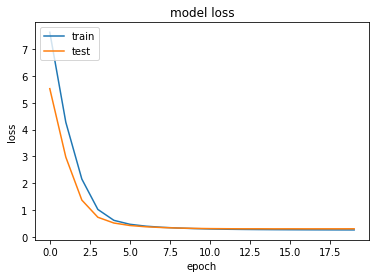

In [526]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference

In [543]:
encoder_model = Model(encoder_inputs, encoder_states, name='encoder_model')

decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name='decoder_model')

In [544]:
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, None)]            0         
_________________________________________________________________
encoder_embedding (Embedding (None, None, 64)          568512    
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 64), (None, 64),  33024     
Total params: 601,536
Trainable params: 601,536
Non-trainable params: 0
_________________________________________________________________


In [545]:
decoder_model.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 64)     568512      decoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_state_input_h (InputLay [(None, 64)]         0                                            
__________________________________________________________________________________________________
decoder_state_input_c (InputLay [(None, 64)]         0                                            
______________________________________________________________________________________

In [546]:
target_token_index = tokenizer.tokenizer.word_index
reverse_target_char_index = {v:k for k,v in target_token_index.items()}
max_decoder_seq_length = decoder_target_data.shape[1]

In [547]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.    
    target_seq[:, :] = target_token_index['start']                    

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            sampled_char = 'stop'
        else:
            sampled_char = reverse_target_char_index[sampled_token_index]
            
        decoded_sentence += sampled_char + ' '

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'stop' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).        
        target_seq = np.zeros((input_seq.shape[0], 1))
        target_seq[:, :] = sampled_token_index     

        # Update states
        states_value = [h, c]

    return decoded_sentence.strip()

In [548]:
for i in range(5):
    input_seq = tokenized_X_train[i:i+1, :]
    output_seq = decode_sequence(input_seq)
    print(output_seq)

stop
stop
stop
stop
stop
